# Multi-Layer Perceptron

Haytham Mohamed

INFS 890 - Spring 2020

In [1225]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping , ReduceLROnPlateau , ModelCheckpoint
from keras.models import load_model
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.2f}'.format

import tensorflow as tf
print(tf.__version__)

1.15.0


In [1226]:
# network structure. 
# not to include the input layer
#net_layers = (8, 5)  # (11,9,8,4)

epochs=1000
batch_size=300

learning_rate = 1e-3
decay = learning_rate / epochs

patience=80

test_split = 0.1
validation_split = 0.2

select_features = True

TRAIN_MODEL = True

# trials
# 11 R2-> -0.12
# 11,16,8,4 R2-> 0.37
# 11,11,6 R2-> -0.2
# 11,8,6 R2->   0.316
# 11,11,8,4 R2->  0.37
# 11, 6 R2-> 0.37

In [1227]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'
models_dir = home_dir + "/models/"

data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
#data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


In [1228]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [1229]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
0,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.07,1.00,1.00,1.00,1.00,1.00,1.00,2.50,0.15,0.24
1,0.06,0.02,0.02,0.02,0.02,0.01,0.01,0.18,0.18,1.00,1.00,1.00,1.00,1.00,1.00,1.89,0.15,0.24
2,0.07,0.03,0.02,0.03,0.02,0.01,0.01,0.44,0.20,1.00,1.00,1.00,1.00,1.00,1.00,1.35,0.15,0.24
3,0.07,0.03,0.02,0.02,0.02,0.01,0.01,0.23,0.17,1.00,1.00,1.00,1.00,1.00,1.00,1.26,0.13,0.24
4,0.07,0.02,0.01,0.02,0.02,0.01,0.01,0.24,0.14,1.00,1.00,1.00,1.00,1.00,1.00,1.28,0.36,0.24


In [1230]:
data.shape

(6766, 18)

# Eliminate outlier noice

In [1231]:
df = data

In [1232]:
df.describe(include="all")

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
count,"6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00"
mean,0.83,0.21,0.02,0.20,0.12,0.05,0.03,0.53,1.83,2.76,2.76,2.76,2.76,2.76,2.76,4.10,5.03,2.97
std,0.62,0.13,0.00,0.13,0.08,0.04,0.01,0.58,1.99,1.10,1.09,1.09,1.09,1.09,1.09,2.08,4.20,3.51
min,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.01,0.50,1.00,1.00,1.00,1.00,1.00,1.10,0.00,0.02
25%,0.19,0.08,0.02,0.05,0.03,0.04,0.02,0.12,0.02,2.00,2.00,2.00,2.00,2.00,2.00,1.92,0.49,0.24
50%,0.84,0.22,0.02,0.20,0.12,0.05,0.03,0.32,1.15,3.00,3.00,3.00,3.00,3.00,3.00,4.21,5.14,0.49
75%,1.29,0.30,0.02,0.30,0.18,0.06,0.04,0.58,3.28,4.00,4.00,4.00,4.00,4.00,4.00,5.78,8.20,5.81
max,2.73,0.91,0.04,0.64,0.34,0.63,0.10,2.53,6.58,4.00,4.00,4.00,4.00,4.00,4.00,9.66,20.13,9.75


shape before (6766, 18)
latency quantiles min 9.65 max 0.24
shape after (4233, 18)


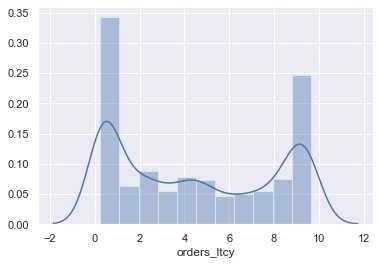

In [1233]:
df = data
print('shape before {}'.format(df.shape))
if 1 == 1:
    minq = df['orders_ltcy'].quantile(0.3)
    maxq = df['orders_ltcy'].quantile(0.99)
    print('latency quantiles min {} max {}'.format(maxq, minq))
    df = df[df['orders_ltcy'] > minq]
    df = df[df['orders_ltcy'] < maxq]
    sns.distplot(df['orders_ltcy'])
print('shape after {}'.format(df.shape))   

In [1234]:
data = df

# Shuffle

In [1235]:
# shuffle the data
from sklearn.utils import shuffle
data = shuffle(data, random_state=360)
print('shape {}'.format(data.shape))
data.head(5)

shape (4233, 18)


,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
2023,1.27,0.32,0.03,0.28,0.18,0.06,0.03,0.39,4.83,2.00,2.00,2.00,2.00,2.00,2.00,5.82,10.13,0.66
6610,1.60,0.28,0.02,0.31,0.20,0.06,0.05,2.12,3.36,4.00,4.00,4.00,4.00,4.00,4.00,6.38,12.29,9.49
4793,0.04,0.05,0.02,0.04,0.02,0.05,0.04,0.05,0.02,4.00,4.00,4.00,4.00,4.00,4.00,1.36,0.00,6.39
3666,1.46,0.32,0.03,0.27,0.21,0.07,0.04,0.40,5.62,3.00,3.00,3.00,3.00,3.00,3.00,6.63,9.91,4.74
6213,1.26,0.30,0.02,0.28,0.14,0.08,0.04,0.36,4.24,4.00,4.00,4.00,4.00,4.00,4.00,5.53,9.07,0.25


In [1236]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))

there are 17 features


# Feature Selection

In [1237]:
feature_list = inputs.columns.values
if select_features:
    clf = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15)
    sfm = SelectFromModel(
                clf,
                threshold='0.02*mean')

    selectedFeatures = sfm.fit(inputs, targets).transform(inputs)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = inputs.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    
    print("columns selected are {}".format(features))

    inputs = inputs[feature_list]
    inputs.head(2)

14 features selected
columns selected are front-end_cpu_use, orders_cpu_use, orders-db_cpu_use, user_cpu_use, user-db_cpu_use, shipping_cpu_use, payment_cpu_use, carts_cpu_use, carts-db_cpu_use, front-end_pods, shipping_pods, carts_pods, nodes_cpu_use, orders_req


In [1238]:
n_inputs = len(feature_list)
n_inputs


14

# Network Architecture

In [1239]:
#net_layers = (11, 8, 5, 2)  # (11,9,8,4)
net_layers = (11, 8)

# Scale Target Variable

In [1240]:
# scale targets for better convergence
y_scaler =  MinMaxScaler()
targets = y_scaler.fit_transform(targets.values.reshape(-1,1))

In [1241]:
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=True, random_state=365)

print("y_train {} , y_test {}".format(y_train.shape, y_test.shape))


y_train (3809, 1) , y_test (424, 1)


# Scaling Features

In [1242]:
x_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)  # fit on training data only
x_test = x_scaler.transform(x_test)

## Function to build a model

In [1243]:
def build_keras_model(nodes = net_layers):   # this does not work with KerasRegressor. interesting
    # create model
    model = Sequential()  
    
    if isinstance(nodes, int) or not nodes:
        model.add(Dense(1, input_dim=n_inputs, kernel_initializer='normal'))
    
    else:
        model.add(Dense(nodes[1], input_dim=n_inputs, kernel_initializer='normal', activation='relu'))
    
        layer = 0
        while layer < len(nodes):
            model.add(Dense(nodes[layer], kernel_initializer='normal', activation='relu'))
            layer = layer + 1
        
        #model.add(Dense(1, kernel_initializer='normal', activation='linear')) 
        model.add(Dense(1, kernel_initializer='normal', activation='linear'))  
    
    adam = Adam(lr=learning_rate, decay=decay)
    
    # or loss= 'mean_absolute_percentage_error'
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
    
    return model


In [1244]:
model = build_keras_model()

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

# save the best model only
mc = ModelCheckpoint(models_dir + 'best_mlp_model.h5'
                     , monitor='val_loss'
                     , mode='min' 
                     , verbose=1
                     #, save_weights_only=True
                     , save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [es, mc, reduce_lr]

if TRAIN_MODEL:
    history = model.fit(x_train, y_train
                    , epochs=epochs
                    , batch_size=batch_size
                    , verbose=1
                    , validation_split=validation_split
                    , shuffle=False
                    , callbacks=callbacks)

print ("Done..!")


Train on 3047 samples, validate on 762 samples
Epoch 1/1000
3047/3047 [==============================] - 6s 2ms/step - loss: 0.3307 - mean_squared_error: 0.3307 - val_loss: 0.3556 - val_mean_squared_error: 0.3556

Epoch 00001: val_loss improved from inf to 0.35562, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 2/1000
3047/3047 [==============================] - 0s 19us/step - loss: 0.3189 - mean_squared_error: 0.3189 - val_loss: 0.3422 - val_mean_squared_error: 0.3422

Epoch 00002: val_loss improved from 0.35562 to 0.34219, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 3/1000
3047/3047 [==============================] - 0s 19us/step - loss: 0.3056 - mean_squared_error: 0.3056 - val_loss: 0.3266 - val_mean_squared_error: 0.3266

Epoch 00003: val_loss improved from 0.34219 to 0.32664, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_ml

3047/3047 [==============================] - 0s 19us/step - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0575 - val_mean_squared_error: 0.0575

Epoch 00051: val_loss improved from 0.05779 to 0.05751, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 52/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0548 - mean_squared_error: 0.0548 - val_loss: 0.0572 - val_mean_squared_error: 0.0572

Epoch 00052: val_loss improved from 0.05751 to 0.05722, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 53/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0545 - mean_squared_error: 0.0545 - val_loss: 0.0569 - val_mean_squared_error: 0.0569

Epoch 00053: val_loss improved from 0.05722 to 0.05695, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 54/1000
3047/3047 [=================

3047/3047 [==============================] - 0s 17us/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0504 - val_mean_squared_error: 0.0504

Epoch 00101: val_loss improved from 0.05043 to 0.05042, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 102/1000
3047/3047 [==============================] - 0s 19us/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0504 - val_mean_squared_error: 0.0504

Epoch 00102: val_loss improved from 0.05042 to 0.05040, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 103/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0504 - val_mean_squared_error: 0.0504

Epoch 00103: val_loss improved from 0.05040 to 0.05039, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 104/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 17us/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0498 - val_mean_squared_error: 0.0498

Epoch 00151: val_loss improved from 0.04985 to 0.04984, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 152/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0498 - val_mean_squared_error: 0.0498

Epoch 00152: val_loss improved from 0.04984 to 0.04983, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 153/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0498 - val_mean_squared_error: 0.0498

Epoch 00153: val_loss improved from 0.04983 to 0.04981, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 154/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 19us/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 0.0494 - val_mean_squared_error: 0.0494

Epoch 00201: val_loss improved from 0.04938 to 0.04938, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 202/1000
3047/3047 [==============================] - 0s 19us/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 0.0494 - val_mean_squared_error: 0.0494

Epoch 00202: val_loss improved from 0.04938 to 0.04937, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 203/1000
3047/3047 [==============================] - 0s 22us/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 0.0494 - val_mean_squared_error: 0.0494

Epoch 00203: val_loss improved from 0.04937 to 0.04936, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 204/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 18us/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0490 - val_mean_squared_error: 0.0490

Epoch 00251: val_loss improved from 0.04901 to 0.04900, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 252/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0490 - val_mean_squared_error: 0.0490

Epoch 00252: val_loss improved from 0.04900 to 0.04899, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 253/1000
3047/3047 [==============================] - 0s 19us/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0490 - val_mean_squared_error: 0.0490

Epoch 00253: val_loss improved from 0.04899 to 0.04899, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 254/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 19us/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0488 - val_mean_squared_error: 0.0488

Epoch 00301: val_loss improved from 0.04877 to 0.04876, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 302/1000
3047/3047 [==============================] - 0s 19us/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0488 - val_mean_squared_error: 0.0488

Epoch 00302: val_loss improved from 0.04876 to 0.04876, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 303/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0488 - val_mean_squared_error: 0.0488

Epoch 00303: val_loss improved from 0.04876 to 0.04875, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 304/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 19us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0486 - val_mean_squared_error: 0.0486

Epoch 00351: val_loss improved from 0.04857 to 0.04857, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 352/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0486 - val_mean_squared_error: 0.0486

Epoch 00352: val_loss improved from 0.04857 to 0.04857, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 353/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0486 - val_mean_squared_error: 0.0486

Epoch 00353: val_loss improved from 0.04857 to 0.04857, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 354/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 18us/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0484 - val_mean_squared_error: 0.0484

Epoch 00401: val_loss improved from 0.04842 to 0.04841, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 402/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0484 - val_mean_squared_error: 0.0484

Epoch 00402: val_loss improved from 0.04841 to 0.04841, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 403/1000
3047/3047 [==============================] - 0s 19us/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0484 - val_mean_squared_error: 0.0484

Epoch 00403: val_loss improved from 0.04841 to 0.04841, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 404/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 19us/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0483 - val_mean_squared_error: 0.0483

Epoch 00451: val_loss improved from 0.04829 to 0.04829, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 452/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0483 - val_mean_squared_error: 0.0483

Epoch 00452: val_loss improved from 0.04829 to 0.04828, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 453/1000
3047/3047 [==============================] - 0s 19us/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0483 - val_mean_squared_error: 0.0483

Epoch 00453: val_loss improved from 0.04828 to 0.04828, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 454/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 18us/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0482 - val_mean_squared_error: 0.0482

Epoch 00501: val_loss improved from 0.04818 to 0.04817, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 502/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0482 - val_mean_squared_error: 0.0482

Epoch 00502: val_loss improved from 0.04817 to 0.04817, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 503/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0482 - val_mean_squared_error: 0.0482

Epoch 00503: val_loss improved from 0.04817 to 0.04817, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 504/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 22us/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0481 - val_mean_squared_error: 0.0481

Epoch 00551: val_loss improved from 0.04807 to 0.04807, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 552/1000
3047/3047 [==============================] - 0s 46us/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0481 - val_mean_squared_error: 0.0481

Epoch 00552: val_loss improved from 0.04807 to 0.04807, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 553/1000
3047/3047 [==============================] - 0s 25us/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0481 - val_mean_squared_error: 0.0481

Epoch 00553: val_loss improved from 0.04807 to 0.04806, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 554/1000
3047/3047 [==============

Epoch 577/1000
3047/3047 [==============================] - 0s 26us/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0480 - val_mean_squared_error: 0.0480

Epoch 00577: val_loss improved from 0.04804 to 0.04804, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 578/1000
3047/3047 [==============================] - 0s 26us/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0480 - val_mean_squared_error: 0.0480

Epoch 00578: val_loss improved from 0.04804 to 0.04804, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 579/1000
3047/3047 [==============================] - 0s 25us/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0480 - val_mean_squared_error: 0.0480

Epoch 00579: val_loss improved from 0.04804 to 0.04804, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 580/1000
3047/3047 

3047/3047 [==============================] - 0s 21us/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0480 - val_mean_squared_error: 0.0480

Epoch 00627: val_loss improved from 0.04797 to 0.04797, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 628/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0480 - val_mean_squared_error: 0.0480

Epoch 00628: val_loss improved from 0.04797 to 0.04797, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 629/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0480 - val_mean_squared_error: 0.0480

Epoch 00629: val_loss improved from 0.04797 to 0.04797, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 630/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 24us/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00678: val_loss improved from 0.04793 to 0.04793, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 679/1000
3047/3047 [==============================] - 0s 21us/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00679: val_loss did not improve from 0.04793
Epoch 680/1000
3047/3047 [==============================] - 0s 20us/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00680: val_loss did not improve from 0.04793
Epoch 681/1000
3047/3047 [==============================] - 0s 22us/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00681: val_loss did not improve from 0.04793
Epoch 682/1000
3047/3047 [=

3047/3047 [==============================] - 0s 21us/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00732: val_loss improved from 0.04788 to 0.04788, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 733/1000
3047/3047 [==============================] - 0s 23us/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00733: val_loss improved from 0.04788 to 0.04788, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 734/1000
3047/3047 [==============================] - 0s 25us/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00734: val_loss improved from 0.04788 to 0.04788, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 735/1000
3047/3047 [==============

Epoch 759/1000
3047/3047 [==============================] - 0s 24us/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00759: val_loss did not improve from 0.04786
Epoch 760/1000
3047/3047 [==============================] - 0s 23us/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00760: val_loss did not improve from 0.04786
Epoch 761/1000
3047/3047 [==============================] - 0s 24us/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00761: val_loss did not improve from 0.04786
Epoch 762/1000
3047/3047 [==============================] - 0s 25us/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00762: val_loss did not improve from 0.04786
Epoch 763/1000
3047/3047 [==============================] - 0s 25us/step - loss: 0.0421 - mean_squared_error: 0.0421


Epoch 00794: val_loss did not improve from 0.04786
Epoch 795/1000
3047/3047 [==============================] - 0s 24us/step - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00795: val_loss did not improve from 0.04786
Epoch 796/1000
3047/3047 [==============================] - 0s 20us/step - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00796: val_loss did not improve from 0.04786
Epoch 797/1000
3047/3047 [==============================] - 0s 20us/step - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00797: val_loss did not improve from 0.04786
Epoch 798/1000
3047/3047 [==============================] - 0s 20us/step - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0479 - val_mean_squared_error: 0.0479

Epoch 00798: val_loss did not improve from 0.04786
Epoch 799/1000
3047/3047 [==============================] - 0s 2

Epoch 853/1000
3047/3047 [==============================] - 0s 22us/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00853: val_loss improved from 0.04784 to 0.04784, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 854/1000
3047/3047 [==============================] - 0s 20us/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00854: val_loss improved from 0.04784 to 0.04784, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 855/1000
3047/3047 [==============================] - 0s 20us/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00855: val_loss improved from 0.04784 to 0.04783, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 856/1000
3047/3047 

Epoch 879/1000
3047/3047 [==============================] - 0s 20us/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00879: val_loss did not improve from 0.04782
Epoch 880/1000
3047/3047 [==============================] - 0s 27us/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00880: val_loss did not improve from 0.04782
Epoch 881/1000
3047/3047 [==============================] - 0s 25us/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00881: val_loss did not improve from 0.04782
Epoch 882/1000
3047/3047 [==============================] - 0s 26us/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00882: val_loss improved from 0.04782 to 0.04782, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 883/10


Epoch 00907: val_loss improved from 0.04780 to 0.04780, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 908/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00908: val_loss did not improve from 0.04780
Epoch 909/1000
3047/3047 [==============================] - 0s 20us/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00909: val_loss did not improve from 0.04780
Epoch 910/1000
3047/3047 [==============================] - 0s 20us/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00910: val_loss improved from 0.04780 to 0.04780, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 911/1000
3047/3047 [==============================] - 0s 19us/step - lo

Epoch 935/1000
3047/3047 [==============================] - 0s 24us/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00935: val_loss improved from 0.04778 to 0.04778, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 936/1000
3047/3047 [==============================] - 0s 22us/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00936: val_loss improved from 0.04778 to 0.04778, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 937/1000
3047/3047 [==============================] - 0s 21us/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00937: val_loss improved from 0.04778 to 0.04778, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 938/1000
3047/3047 

Epoch 990/1000
3047/3047 [==============================] - 0s 21us/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0477 - val_mean_squared_error: 0.0477

Epoch 00990: val_loss improved from 0.04772 to 0.04772, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 991/1000
3047/3047 [==============================] - 0s 19us/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0477 - val_mean_squared_error: 0.0477

Epoch 00991: val_loss improved from 0.04772 to 0.04772, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 992/1000
3047/3047 [==============================] - 0s 21us/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0477 - val_mean_squared_error: 0.0477

Epoch 00992: val_loss did not improve from 0.04772
Epoch 993/1000
3047/3047 [==============================] - 0s 26us/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 

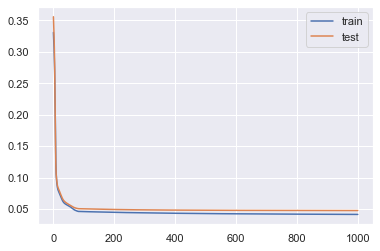

In [1245]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [1246]:
val_loss = history.history['val_loss']
val_loss_df = pd.DataFrame(val_loss)

print("Model Validation MSE mean: %.2f  std: (%.2f)" % \
      (val_loss_df.mean(), val_loss_df.std()))


Model Validation MSE mean: 0.05  std: (0.02)


In [1247]:
# load the saved model
saved_model = load_model(models_dir + 'best_mlp_model.h5')


In [1248]:
# evaluate the model
train_loss, train_mse = saved_model.evaluate(x_train, y_train, verbose=0)
test_loss, test_mse = saved_model.evaluate(x_test, y_test, verbose=0)
print('Train MSE: %.3f, Test MSE: %.3f' % (train_mse, test_mse))

Train MSE: 0.043, Test MSE: 0.038


In [1249]:
#regressor.fit(x_train, y_train)
y_hat = saved_model.predict(x_train)

#y_train = y_scaler.inverse_transform(y_train.reshape(-1,1))
#y_hat = y_scaler.inverse_transform(y_hat.reshape(-1,1))

In [1250]:
y_train = y_train.reshape(-1)

In [1251]:
y_train_together = pd.DataFrame(y_train, columns=['y_train_true'])
y_train_together['y_train_pred'] = y_hat
#y_train_together = y_train_together.reshape(-1,2)
y_train_together.head(5)

,y_train_true,y_train_pred
0,0.19,0.47
1,0.00,0.01
2,0.14,0.48
3,0.72,0.31
4,0.00,0.01


In [1252]:
r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))

R2 (training) = 0.6943618939834744


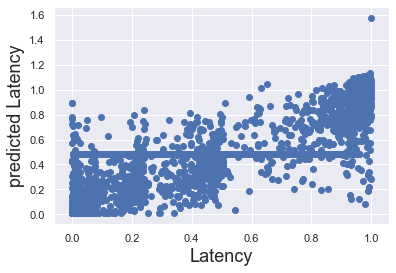

In [1253]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

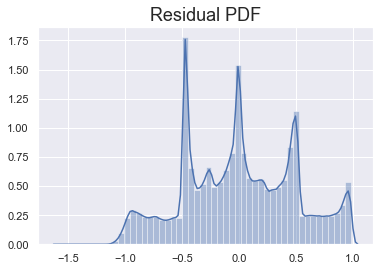

In [1254]:
#y_train = y_train.values
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

In [1255]:
# evaluation mean_absolute_percentage_error
train_error =  y_train - y_hat
train_error

mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Train Residual mean: %.2f std: %.2f  min; %.2f max: %.2f" \
      % (mean_error, std_error, min_error, max_error))

Train Residual mean: 0.00 std: 0.49  min; -1.57 max: 0.99


### Testing

In [1256]:
y_hat_test = saved_model.predict(x_test)

#y_test = y_scaler.inverse_transform(y_test.reshape(-1,1))
#y_hat_test = y_scaler.inverse_transform(y_hat_test.reshape(-1,1))



In [1257]:
y_test = y_test.reshape(-1)

In [1258]:
y_test_together = pd.DataFrame(y_test, columns=['y_test_true'])
y_test_together['y_test_pred'] = y_hat_test
y_test_together.head(5)

,y_test_true,y_test_pred
0,0.06,0.43
1,0.91,1.01
2,0.61,0.48
3,0.99,0.89
4,0.97,1.03


<function matplotlib.pyplot.show(*args, **kw)>

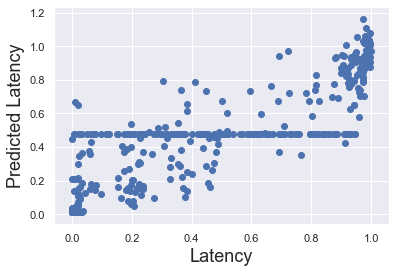

In [1259]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

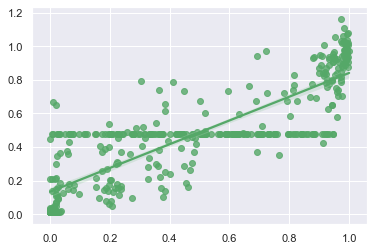

In [1260]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [1261]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
#y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.53,1.07
1,2.74,2.50
2,1.62,1.85
3,2.43,2.68
4,2.80,2.65


In [1262]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.53,1.07,0.47,44.01
1,2.74,2.50,0.25,9.90
2,1.62,1.85,-0.23,12.51
3,2.43,2.68,-0.25,9.45
4,2.80,2.65,0.15,5.83
...,...,...,...,...
419,1.36,1.25,0.11,8.97
420,2.57,2.00,0.57,28.37
421,1.62,1.05,0.57,53.82
422,1.45,1.27,0.18,14.14


In [1263]:
perf.describe()

,prediction,target,residual,difference%
count,424.00,424.00,424.00,424.00
mean,1.66,1.69,-0.03,14.43
std,0.52,0.61,0.33,14.72
min,1.01,1.00,-0.96,0.04
25%,1.21,1.08,-0.20,3.02
50%,1.62,1.52,-0.00,10.23
75%,1.92,2.32,0.14,22.10
max,3.19,2.72,0.94,92.81


In [1264]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
83,1.01,1.01,-0.00,0.04
294,1.01,1.01,0.00,0.07
257,2.06,2.07,-0.00,0.09
356,1.63,1.63,0.00,0.11
53,1.22,1.23,-0.00,0.13
15,1.01,1.02,-0.00,0.15
388,1.01,1.02,-0.00,0.15
33,1.01,1.02,-0.00,0.15
85,1.01,1.01,0.00,0.17
335,1.01,1.01,0.00,0.17


# Prediction Accuracy

In [1265]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

R2 (testing) = 0.7120401502646694


In [1266]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.19391242918190815
